In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import cv2
import numpy as np
import os
import scipy.io as io
import matplotlib.pyplot as plt
import pickle

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import random
from tqdm import tqdm
from scipy.spatial.transform import Rotation

from custom_data_loader import AugmentationManager


In [17]:
IMG_SIZE=96

In [545]:
K1 = np.array([[1.066778e+03, 0.000000e+00, 3.129869e+02],
               [0.000000e+00, 1.067487e+03, 2.413109e+02],
               [0.000000e+00, 0.000000e+00, 1.000000e+00]])

K2 = np.array([[1077.836, 0, 323.7872],
               [0, 1078.189, 279.6921],
               [0,        0,        1]])

verts = [
        [-0.01,0,0],
        [0.08,0.05,0.0],
        [-0.1,0.045,0.0],
        [-0.03,-0.11,0.023],
        [-0.03,-0.11,-0.023],
        [0.055,-0.11,0.023],
        [0.055,-0.11,-0.023]
        ]
verts  = np.array(verts)

def get_x_y(verts, pose, idx):
    t = pose[4:,None]
    quat = -np.array([*pose[1:4], pose[0]])
    R = np.array(Rotation.from_quat(quat).as_matrix())

    K_ = K1 if idx <= 23820 else K2

    verts_2d = np.matmul(K_, np.matmul(R, verts.T) + t).T
    verts_2d = verts_2d[:,:2] / verts_2d[:,2,None]
    return verts_2d

In [10]:
ycb_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\datasets\\ycb_video_sicrod"
power_screwdriver_name = "power_screwdriver"
poses_file_name = "035_power_drill.txt"
poses_file_path = os.path.join(ycb_path,poses_file_name)
frames_path = os.path.join(ycb_path,power_screwdriver_name)

poses = np.loadtxt(poses_file_path)

In [11]:
os.listdir(frames_path)

['0006',
 '0009',
 '0010',
 '0011',
 '0012',
 '0018',
 '0024',
 '0030',
 '0037',
 '0038',
 '0050',
 '0054',
 '0056',
 '0059',
 '0077',
 '0081',
 '0083',
 '0086',
 '0088']

In [292]:
def get_mask(points, original_frame_shape):
    
    SIZE_X = original_frame_shape[1]
    SIZE_Y = original_frame_shape[0]
    joint_masks = []
    joint_idx = 0
    joints_number = len(points)
    mask = np.zeros((7,IMG_SIZE,IMG_SIZE))
    for i, point in enumerate(points):
        
        x = point[0]
        y = point[1]

        x = int(x/(SIZE_X/IMG_SIZE))
        y = int(y/(SIZE_Y/IMG_SIZE))
        color = (255,255,255)
        mask[i] = cv2.circle(mask[i],(x,y),7,color, -1)
        joint_masks.append(mask[i])
        
    #joint_masks = np.array(joint_masks)
    joint_masks = np.swapaxes(joint_masks, 0,-1)
    joint_masks = np.swapaxes(joint_masks, 0,1)
            
    return joint_masks/255.

In [557]:
# all_types = ['0006', '0009', '0010', '0012', '0018', '0024', '0030', '0038',
#                 '0050','0056','0059','0077','0081','0083','0086','0088','0011', '0037', '0054']

all_types = ['0006', '0011']
train_types = ['0006']
val_types = ['0011']

dir_types = os.listdir(frames_path)
frames_poses_dict={}
idx = 0


for dir_type in dir_types:
    dir_1 = os.path.join(frames_path,dir_type)
    if dir_type in all_types:
        frames_poses_dict[dir_type] = {}
        frames_poses_dict[dir_type]['color_frames'] = []
        frames_poses_dict[dir_type]['depth_frames'] = []
        frames_poses_dict[dir_type]['frames_idx'] = []
        frames_poses_dict[dir_type]['poses'] = []
        for file_name in tqdm(os.listdir(dir_1)):
            if "color" in file_name:
                frame_path = os.path.join(dir_1,file_name)
                frame = cv2.imread(frame_path)
                frame = cv2.resize(frame,(IMG_SIZE,IMG_SIZE))/255.
                frames_poses_dict[dir_type]['color_frames'].append(frame)
                frames_poses_dict[dir_type]['poses'].append(poses[idx])
                frames_poses_dict[dir_type]['frames_idx'].append(idx)
                idx += 1
            if "depth" in file_name:
                frame_path = os.path.join(dir_1,file_name)
                frame = cv2.imread(frame_path)
                frame = cv2.resize(frame,(IMG_SIZE,IMG_SIZE))/255.
                frames_poses_dict[dir_type]['depth_frames'].append(frame)
    else:
        print(dir_type, idx)
        for file_name in os.listdir(dir_1):
            if "color" in file_name:
                idx += 1


100%|█████████████████████████████████████████████████████████████████████████████| 8125/8125 [00:22<00:00, 362.26it/s]


0009 1625
0010 3215


100%|█████████████████████████████████████████████████████████████████████████████| 5530/5530 [00:15<00:00, 353.58it/s]


0012 6218
0018 7321
0024 8744
0030 10144
0037 11267
0038 13423
0050 16889
0054 18805
0056 20733
0059 21958
0077 23821
0081 24599
0083 25583
0086 26535
0088 27431


In [558]:
def power_driver_generator(frames_poses_dict,dir_type,idx):
    points = get_x_y(verts, frames_poses_dict[dir_type]['poses'][idx],frames_poses_dict[dir_type]['frames_idx'][idx])
    print(frames_poses_dict[dir_type]['poses'][idx])
    print(points/5.7)
    mask = get_mask(points, original_frame_shape = [480,640])
    color_frame = frames_poses_dict[dir_type]['color_frames'][idx].copy()
    color_frame, mask = augmentator.augment(color_frame, mask)
    return color_frame, mask

In [559]:
aug_pipeline = [
        #{"aug_type": "channel_shift", "parameters": []},
        #{"aug_type": "rotation", "parameters": [50]},
        #{"aug_type": "flip", "parameters": []},
        #{"aug_type": "random_rectangles", "parameters": [10, 0.2, True]},
    ]

augmentator = AugmentationManager(aug_pipeline)

In [568]:
img, mask = power_driver_generator(frames_poses_dict,'0011', 900)

[ 0.158792 -0.499111 -0.201885  0.827596 -0.075247  0.034328  0.782548]
[[38.15650054 49.37077656]
 [24.18462077 49.87896991]
 [47.55627012 30.88016244]
 [38.66800029 66.4312204 ]
 [47.31590851 68.75963708]
 [28.43543884 77.55950183]
 [37.54479927 80.35399307]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


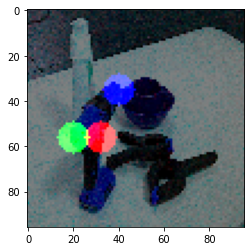

In [569]:
plt.imshow(img/2+mask[:,:,0:3])